# Projet Data Science - Simulateur de DPE
## ENSAE Paris - 2A

Membres du groupe : 
- Wiam LACHQER , Amine RAZIG , Julien BOUDIER

Ce projet Python a été créé dans le but de fournir des visualisations variées des données et de mettre en place un simulateur de Diagnostic de Performance Energétique (DPE) à partir de la base de données de l'ADEME (Agence de la Transition Écologique).

## Objectifs du Projet

1. **Visualisations de Données :** Le projet propose différentes visualisations des données issues de la base de l'ADEME. Ces visualisations permettent une compréhension approfondie des caractéristiques énergétiques des logements.

2. **Simulateur de DPE :** Un simulateur de DPE a été développé en utilisant les données de l'ADEME. Ce simulateur permet d'estimer la performance énergétique d'un logement en fonction de divers paramètres.

## Importation des librairies

In [2]:
#!pip install -q -r requirements.txt

In [12]:
import fetchdata
import eda
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Choix des variables et récupération des données

In [2]:
chosen_variables=['Etiquette_GES',
                  'Etiquette_DPE',
                  'Année_construction',
                  'Type_bâtiment',
                  'Hauteur_sous-plafond',
                  'Surface_habitable_logement',
                  'Classe_altitude',
                  'Coordonnée_cartographique_X_(BAN)',     
                  'Coordonnée_cartographique_Y_(BAN)',
                  'N°_région_(BAN)',
                  'Conso_5_usages_é_finale',
                  'Conso_5_usages/m²_é_finale',
                  'Conso_chauffage_é_finale',
                  'Emission_GES_5_usages',
                  'Emission_GES_5_usages_par_m²',
                  'Conso_5_usages_é_finale_énergie_n°1',
                  'Coût_total_5_usages_énergie_n°1',
                  'Conso_5_usages_é_finale_énergie_n°2',
                  'Coût_total_5_usages_énergie_n°2',
                  'Conso_5_usages_é_finale_énergie_n°3',
                  'Coût_total_5_usages_énergie_n°3',
                  'Coût_total_5_usages',
                  'Qualité_isolation_enveloppe',
                  'Qualité_isolation_menuiseries',
                  'Qualité_isolation_murs',
                  'Qualité_isolation_plancher_bas',
                  'Type_énergie_principale_chauffage',
                  'Type_installation_ECS',          
                  'Type_ventilation']
df = fetchdata.get_dpe(chosen_variables, size =50000)


Fetched 10000 observations
Fetched 20000 observations
Fetched 30000 observations
Fetched 40000 observations
Fetched 50000 observations


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Coût_total_5_usages_énergie_n°3      11630 non-null  float64
 1   Coût_total_5_usages_énergie_n°2      40925 non-null  float64
 2   Coût_total_5_usages_énergie_n°1      50000 non-null  float64
 3   Qualité_isolation_enveloppe          50000 non-null  object 
 4   Type_installation_ECS                49770 non-null  object 
 5   Coût_total_5_usages                  50000 non-null  float64
 6   Emission_GES_5_usages                50000 non-null  float64
 7   Qualité_isolation_menuiseries        50000 non-null  object 
 8   Qualité_isolation_murs               50000 non-null  object 
 9   Etiquette_GES                        50000 non-null  object 
 10  Conso_5_usages_é_finale_énergie_n°1  50000 non-null  float64
 11  Conso_5_usages_é_finale_éner

# Préparation des données

## Données manquantes

On choisit de supprimer les colonnes avec beaucoup de valeurs manquantes puis lignes avec des valeurs manquantes.

In [4]:
cols_to_drop = ['Coordonnée_cartographique_X_(BAN)',
                'Coordonnée_cartographique_Y_(BAN)',
                'N°_région_(BAN)',
                'Coût_total_5_usages_énergie_n°3',
                'Conso_5_usages_é_finale_énergie_n°3',
                'Type_ventilation',
                '_score']

df.drop(cols_to_drop, axis=1, inplace=True)

In [5]:
df = df.dropna(axis=0, how='any')

## Encodage des variables

On utilise pour encoder les variables textuelles :
    Le OneHotEncoding pour les variables dont les valeurs peuvent être classées (qualité de l'isolation par exemple)
    Le LabelEncoder pour les autres (type de bâtiment par exemple)

In [9]:
df = eda.label_encode(df, ["Qualité_isolation_enveloppe","Qualité_isolation_menuiseries","Qualité_isolation_murs","Etiquette_GES",
                       "Etiquette_DPE","Qualité_isolation_plancher_bas","Classe_altitude",])

df = eda.one_hot_encode(df, ["Type_installation_ECS","Type_bâtiment","Type_énergie_principale_chauffage",])


KeyError: "None of [Index(['Type_installation_ECS', 'Type_bâtiment',\n       'Type_énergie_principale_chauffage'],\n      dtype='object')] are in the [columns]"

In [7]:
print(df["Type_installation_ECS"].unique())

KeyError: 'Type_installation_ECS'

# Statistiques descriptives

In [ ]:
df.head()

,Coût_total_5_usages_énergie_n°2,Coût_total_5_usages_énergie_n°1,Qualité_isolation_enveloppe,Coût_total_5_usages,Emission_GES_5_usages,Qualité_isolation_menuiseries,Qualité_isolation_murs,Etiquette_GES,Conso_5_usages_é_finale_énergie_n°1,Conso_5_usages_é_finale_énergie_n°2,...,Type_énergie_principale_chauffage_Bois – Plaquettes d’industrie,Type_énergie_principale_chauffage_Bois – Plaquettes forestières,Type_énergie_principale_chauffage_Charbon,Type_énergie_principale_chauffage_Fioul domestique,Type_énergie_principale_chauffage_GPL,Type_énergie_principale_chauffage_Gaz naturel,Type_énergie_principale_chauffage_Propane,Type_énergie_principale_chauffage_Réseau de Chauffage urbain,Type_énergie_principale_chauffage_Électricité,Type_énergie_principale_chauffage_Électricité d'origine renouvelable utilisée dans le bâtiment
0,342.0,1841.0,1,2702.0,5960.8,0,1,2,24645.6,10676.1,...,0,0,0,0,0,1,0,0,0,0
1,913.7,913.7,1,913.7,2152.0,2,1,3,9648.4,9648.4,...,0,0,0,0,0,0,0,0,1,0
4,2337.8,2337.8,1,2337.8,3672.5,2,1,3,17952.1,17952.1,...,0,0,0,0,0,0,0,0,1,0
6,812.4,812.4,1,812.4,794.8,2,1,2,12765.4,12765.4,...,0,0,0,0,0,1,0,0,0,0
7,1360.5,1360.5,1,1360.5,2673.1,2,1,3,10033.7,10033.7,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
df.describe()

,Coût_total_5_usages_énergie_n°2,Coût_total_5_usages_énergie_n°1,Qualité_isolation_enveloppe,Coût_total_5_usages,Emission_GES_5_usages,Qualité_isolation_menuiseries,Qualité_isolation_murs,Etiquette_GES,Conso_5_usages_é_finale_énergie_n°1,Conso_5_usages_é_finale_énergie_n°2,...,Type_énergie_principale_chauffage_Bois – Plaquettes d’industrie,Type_énergie_principale_chauffage_Bois – Plaquettes forestières,Type_énergie_principale_chauffage_Charbon,Type_énergie_principale_chauffage_Fioul domestique,Type_énergie_principale_chauffage_GPL,Type_énergie_principale_chauffage_Gaz naturel,Type_énergie_principale_chauffage_Propane,Type_énergie_principale_chauffage_Réseau de Chauffage urbain,Type_énergie_principale_chauffage_Électricité,Type_énergie_principale_chauffage_Électricité d'origine renouvelable utilisée dans le bâtiment
count,38830.000000,38830.000000,38830.000000,38830.000000,38830.000000,38830.000000,38830.000000,38830.000000,38830.000000,38830.000000,...,38830.000000,38830.000000,38830.000000,38830.000000,38830.000000,38830.000000,38830.000000,38830.000000,38830.00000,38830.000000
mean,947.285282,1350.240149,1.114087,1495.813778,3230.298802,1.704224,1.219676,2.731136,15888.509400,10107.369714,...,0.000386,0.000515,0.000386,0.119109,0.035540,0.504249,0.001545,0.205640,0.09503,0.000386
std,1249.730967,1305.770796,0.774051,1635.757786,4273.300348,0.955337,0.854265,1.267115,16419.186148,16307.756139,...,0.019651,0.022690,0.019651,0.323921,0.185141,0.499988,0.039279,0.404174,0.29326,0.019651
min,0.000000,0.000000,0.000000,65.000000,3.300000,0.000000,0.000000,0.000000,510.200000,9.300000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,198.700000,607.900000,1.000000,779.200000,1166.000000,1.000000,1.000000,2.000000,6676.000000,99.400000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,339.700000,1016.500000,1.000000,1179.450000,2219.350000,2.000000,1.000000,3.000000,11362.300000,1890.050000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000
75%,1425.200000,1694.000000,1.000000,1806.000000,4047.100000,2.000000,1.000000,3.000000,19800.900000,15979.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000
max,22472.000000,52025.000000,3.000000,101690.000000,242281.000000,3.000000,3.000000,6.000000,661057.900000,357835.700000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


La valeur maximale est souvent nettement supérieure au 3ème quartile. On décide de supprimer les outliers plutôt que de les imputer car on dispose d'une grande quantité de données.

In [ ]:
cleaned_df = eda.remove_outliers(df)

In [ ]:
eda.correlation(df)

,Coût_total_5_usages_énergie_n°2,Coût_total_5_usages_énergie_n°1,Qualité_isolation_enveloppe,Coût_total_5_usages,Emission_GES_5_usages,Qualité_isolation_menuiseries,Qualité_isolation_murs,Etiquette_GES,Conso_5_usages_é_finale_énergie_n°1,Conso_5_usages_é_finale_énergie_n°2,...,Type_énergie_principale_chauffage_Bois – Plaquettes d’industrie,Type_énergie_principale_chauffage_Bois – Plaquettes forestières,Type_énergie_principale_chauffage_Charbon,Type_énergie_principale_chauffage_Fioul domestique,Type_énergie_principale_chauffage_GPL,Type_énergie_principale_chauffage_Gaz naturel,Type_énergie_principale_chauffage_Propane,Type_énergie_principale_chauffage_Réseau de Chauffage urbain,Type_énergie_principale_chauffage_Électricité,Type_énergie_principale_chauffage_Électricité d'origine renouvelable utilisée dans le bâtiment
Coût_total_5_usages_énergie_n°2,1.000000,0.841538,-0.038164,0.705191,0.677354,-0.145197,-0.127105,0.326743,0.814535,0.957116,...,-0.004684,-0.014157,0.004428,0.402883,-0.069698,-0.192042,-0.022578,-0.235849,0.192442,-0.009896
Coût_total_5_usages_énergie_n°1,0.841538,1.000000,-0.047970,0.940589,0.894180,-0.144270,-0.149394,0.398467,0.946380,0.821428,...,-0.015366,-0.020786,-0.001828,0.368057,0.036318,-0.165562,0.016555,-0.253905,0.170912,-0.000067
Qualité_isolation_enveloppe,-0.038164,-0.047970,1.000000,-0.041449,-0.042908,0.032573,0.105425,-0.072181,-0.050216,-0.034212,...,-0.002897,0.047978,-0.002897,-0.017734,-0.004931,0.028027,-0.010034,-0.016957,0.007830,-0.011363
Coût_total_5_usages,0.705191,0.940589,-0.041449,1.000000,0.936685,-0.108747,-0.120663,0.306928,0.903049,0.700877,...,-0.007159,-0.015161,-0.003209,0.287497,0.039196,-0.132143,0.016944,-0.198661,0.118985,0.002021
Emission_GES_5_usages,0.677354,0.894180,-0.042908,0.936685,1.000000,-0.105487,-0.121063,0.482052,0.894546,0.683889,...,-0.012846,-0.014788,0.054983,0.399038,-0.003069,-0.047748,0.006086,-0.215513,-0.036752,-0.009704
Qualité_isolation_menuiseries,-0.145197,-0.144270,0.032573,-0.108747,-0.105487,1.000000,0.130582,-0.144626,-0.137152,-0.149114,...,0.026664,0.012969,-0.007632,-0.082561,-0.037396,0.005732,-0.004978,0.134517,-0.062379,-0.021350
Qualité_isolation_murs,-0.127105,-0.149394,0.105425,-0.120663,-0.121063,0.130582,1.000000,-0.183357,-0.145925,-0.125356,...,-0.005055,0.014093,-0.005055,-0.094094,0.031240,-0.080269,0.001396,0.216379,-0.072537,-0.020397
Etiquette_GES,0.326743,0.398467,-0.072181,0.306928,0.482052,-0.144626,-0.183357,1.000000,0.405561,0.317408,...,-0.032029,-0.031014,0.050715,0.395208,0.078606,0.137373,0.013522,-0.264669,-0.241041,-0.032029
Conso_5_usages_é_finale_énergie_n°1,0.814535,0.946380,-0.050216,0.903049,0.894546,-0.137152,-0.145925,0.405561,1.000000,0.855405,...,-0.006695,-0.015289,0.029554,0.347881,-0.051705,-0.099516,-0.006251,-0.229304,0.070749,-0.009500
Conso_5_usages_é_finale_énergie_n°2,0.957116,0.821428,-0.034212,0.700877,0.683889,-0.149114,-0.125356,0.317408,0.855405,1.000000,...,-0.009555,-0.012037,0.036725,0.394858,-0.088263,-0.168826,-0.017797,-0.236195,0.156865,-0.006698


# Nuage de points

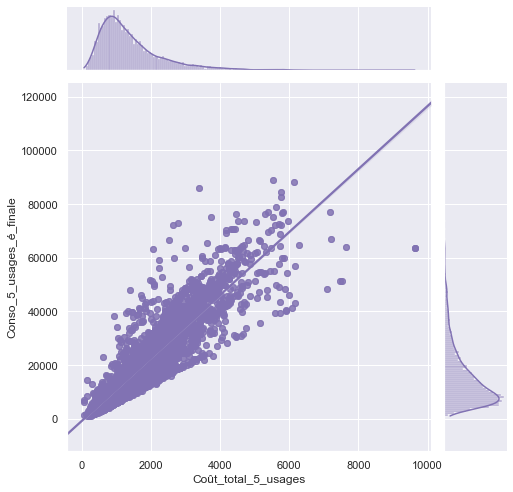

In [ ]:
eda.linreg_marg_dist(cleaned_df,"Coût_total_5_usages","Conso_5_usages_é_finale")

# Détection des valeurs manquantes et data pre-processing

La base de données contient plusieurs colonnes qu’on peut utiliser comme variables pour prédire la consommation de l’énergie par m², un nettoyage et un encodage de données sont alors nécessaires pour pouvoir sélectionner les colones à utiliser et avoir des données intérprétables par les modèles de machine learning (régression linéaire, XGBoost, CATBoost).

Le plan de ce qui suit:
- * Importation des données.
- * Suppression des colonnes dont plus de 60% de leurs valeurs sont manquantes.
- * Analyse des corrélations entre les variables continues et de leurs distribution.
- * Traitement des valeurs aberrantes 
- * Visualisation et encodage des variables catégorielles
- * Utilisation de la régularisation de Lasso pour sélectionner les variables explicatives les plus signifivcatives

In [2]:

import fetchdata

chosen_variables=['Type_énergie_n°1',
                  'Type_énergie_n°2',
                  'Type_énergie_n°3',
                  'Etiquette_GES',
                  'Etiquette_DPE',
                  #'Année_construction',
                  'Type_bâtiment',
                  'Période_construction',
                  'Hauteur_sous-plafond',
                  'Surface_habitable_logement',
                  'Classe_altitude',
                  'Zone_climatique_',
                  #'Nom__commune_(BAN)',
                  #'Coordonnée_cartographique_X_(BAN)',     
                  #'Coordonnée_cartographique_Y_(BAN)',
                  #'N°_région_(BAN)',
                  'Conso_5_usages_é_finale',
                  'Conso_5_usages/m²_é_finale',
                  'Conso_chauffage_é_finale',
                  'Emission_GES_5_usages',
                  'Emission_GES_5_usages_par_m²',
                  'Conso_5_usages_é_finale_énergie_n°1',
                  #'Coût_total_5_usages_énergie_n°1',
                  'Conso_5_usages_é_finale_énergie_n°2',
                  'Coût_total_5_usages_énergie_n°2',
                  'Conso_5_usages_é_finale_énergie_n°3',
                  #'Coût_total_5_usages_énergie_n°3',
                  #'Coût_total_5_usages',
                  'Qualité_isolation_enveloppe',
                  'Qualité_isolation_menuiseries',
                  'Qualité_isolation_murs',
                  'Qualité_isolation_plancher_bas',
                  'Type_énergie_principale_chauffage',
                  'Type_installation_ECS',
                  'Type_installation_solaire',
                  'Surface_climatisée',               
                  'Type_ventilation']

df_DPE = fetchdata.get_dpe(chosen_variables, size =100000)

Fetched 10000 observations
Fetched 20000 observations
Fetched 30000 observations
Fetched 40000 observations
Fetched 50000 observations
Fetched 60000 observations
Fetched 70000 observations
Fetched 80000 observations
Fetched 90000 observations
Fetched 100000 observations


In [3]:
import eda

eda.create_unique(df_DPE)

,Column_name,Data_type,Number_of_unique,Number_of_missing,Unique_values,Rate_of_missing
0,Type_énergie_n°3,object,11,76740,"[Électricité, nan, Bois – Bûches, GPL, Gaz nat...",0.7674
0,Type_énergie_n°1,object,12,0,"[Gaz naturel, Réseau de Chauffage urbain, Élec...",0.0000
0,Coût_total_5_usages_énergie_n°2,float64,5227,18150,More than 15 unique values,0.1815
0,Type_énergie_n°2,object,12,18150,"[Bois – Bûches, Électricité, Gaz naturel, Rése...",0.1815
0,Qualité_isolation_enveloppe,object,4,0,"[insuffisante, très bonne, bonne, moyenne]",0.0000
0,Type_installation_ECS,object,3,460,"[installation individuelle, nan, installation ...",0.0046
0,Emission_GES_5_usages,float64,8438,0,More than 15 unique values,0.0000
0,Qualité_isolation_menuiseries,object,4,0,"[bonne, moyenne, très bonne, insuffisante]",0.0000
0,Qualité_isolation_murs,object,4,0,"[insuffisante, très bonne, moyenne, bonne]",0.0000
0,Etiquette_GES,object,7,0,"[C, D, B, F, E, A, G]",0.0000


On supprime "Surface_climatisée, Type_installation_solaire, _score, Conso_5_usages_é_finale_énergie_n°3,Coût_total_5_usages_énergie_n°3, Type_énergie_n°3" puisque le nombre de valeurs manquantes dépasse 0,6*le nombre des observations. La variable "type_ventilation" contient un nombre assez élevé de valeurs manquantes(0,31), mais on l’utilisera pour la prédiction puisque c’est une variable pertinente.

In [4]:
# Suppression des colonnes

cols_to_drop = ["Surface_climatisée", 
                "Type_installation_solaire", 
                "_score", 
                "Conso_5_usages_é_finale_énergie_n°3",
                "Type_énergie_n°3"]

df = df_DPE.drop(cols_to_drop, axis=1, inplace=False)

In [5]:
# Suppression des lignes ayant des valeurs manquantes

df = df.dropna(axis=0, how='any')

In [6]:
print(len(df))

48520


La base de données qu’on a retenue contient 48520 observations, ce qui est suffisant pour entrainer le modèle.

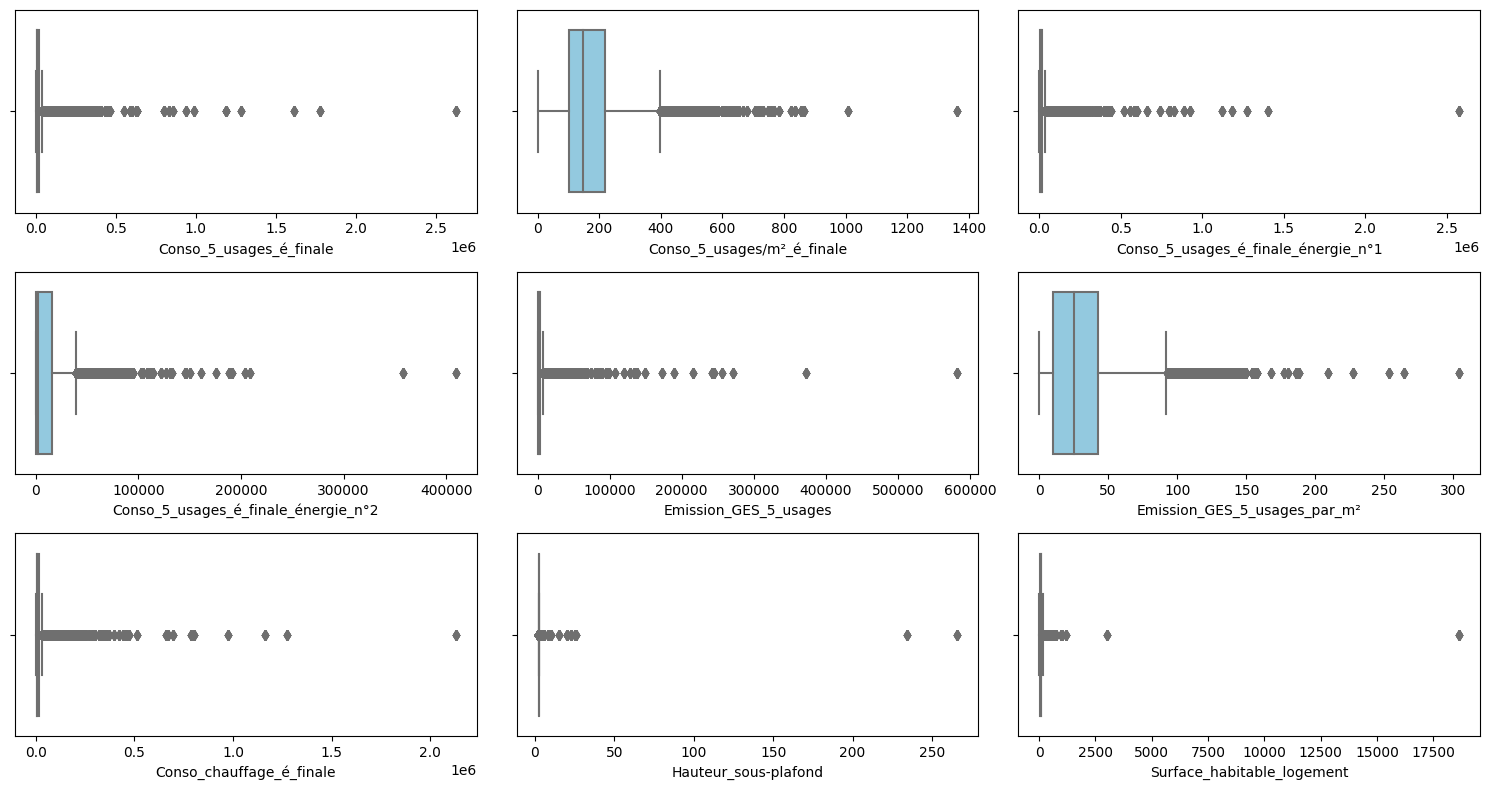

In [7]:
continuous_variables =['Conso_5_usages_é_finale','Conso_5_usages/m²_é_finale','Conso_5_usages_é_finale_énergie_n°1','Conso_5_usages_é_finale_énergie_n°2', 'Emission_GES_5_usages','Emission_GES_5_usages_par_m²','Conso_chauffage_é_finale','Hauteur_sous-plafond','Surface_habitable_logement']

eda.boxplot(df_DPE,continuous_variables)

In [8]:
# Détection du nombre des valeurs aberrantes par la méthode des quantiles

eda.Outliers(df,continuous_variables)

,liste_val_aberrantes,nombre_val_aberrantes,variable
0,NaN,2840,Conso_5_usages_é_finale
0,NaN,1680,Conso_5_usages/m²_é_finale
0,NaN,2580,Conso_5_usages_é_finale_énergie_n°1
0,NaN,5750,Conso_5_usages_é_finale_énergie_n°2
0,NaN,2860,Emission_GES_5_usages
0,NaN,1710,Emission_GES_5_usages_par_m²
0,NaN,3190,Conso_chauffage_é_finale
0,NaN,7700,Hauteur_sous-plafond
0,NaN,3310,Surface_habitable_logement


On choisit de prédire directement la consommation de l’énergie et le volume des émissions par m² puisque ces deux variables contiennent le minimum de valeurs aberrantes. Les variables explicatives continues sont la surface du logement et la hauteur sous plafond.

In [9]:
# Standardisation des variables  explicatives continues

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
continuous_explicative = ["Surface_habitable_logement","Hauteur_sous-plafond"]
df[continuous_explicative] = scaler.fit_transform(df[continuous_explicative])

In [10]:
# Corrélation entre les variables continues 

corr = df.loc[:,["Surface_habitable_logement","Hauteur_sous-plafond","Conso_5_usages/m²_é_finale","Emission_GES_5_usages_par_m²"]].corr()
corr.style.background_gradient(cmap='coolwarm')

,Surface_habitable_logement,Hauteur_sous-plafond,Conso_5_usages/m²_é_finale,Emission_GES_5_usages_par_m²
Surface_habitable_logement,1.000000,0.006348,-0.027395,-0.024460
Hauteur_sous-plafond,0.006348,1.000000,0.096663,0.106964
Conso_5_usages/m²_é_finale,-0.027395,0.096663,1.000000,0.829213
Emission_GES_5_usages_par_m²,-0.024460,0.106964,0.829213,1.000000


On remarque une forte corrélation positive entre la consommation énergétique et le volume des émissions de gaz à effet de serre.
Ces deux variables ont les mêmes corrélations avec les variables explicatives retenus. Nous pouvons envisager de prédire l’une à partir de l’autre.

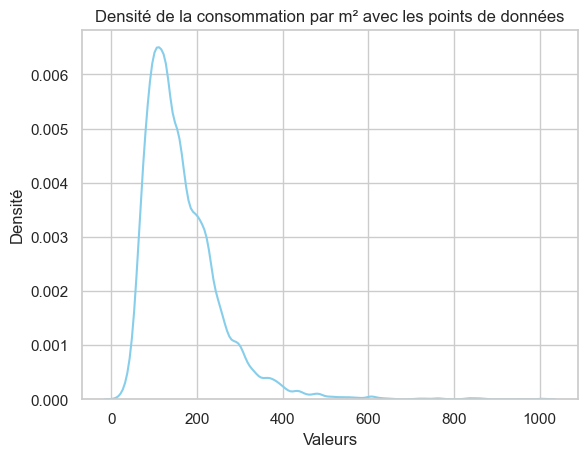

In [13]:
sns.set(style="whitegrid")
sns.kdeplot(df["Conso_5_usages/m²_é_finale"], color="skyblue")
plt.title('Densité de la consommation par m² avec les points de données')
plt.xlabel('Valeurs')
plt.ylabel('Densité')
plt.show()

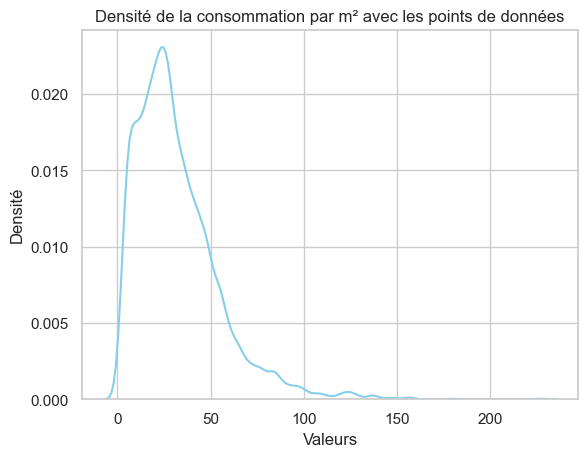

In [ ]:
sns.set(style="whitegrid")
sns.kdeplot(df["Emission_GES_5_usages_par_m²"], color="skyblue")
plt.title('Densité de la consommation par m² avec les points de données')
plt.xlabel('Valeurs')
plt.ylabel('Densité')
plt.show()

Les deux variables à prédire ont des distribution similaires, 

## Variables catégorielles

In [14]:
categorical_variables = ['Type_énergie_n°1',       # 11 valeurs uniques
                  'Type_énergie_n°2',              # 8 valeurs uniques
                  'Etiquette_GES',
                  'Etiquette_DPE',                 # 7 valeurs uniques
                  'Type_bâtiment',                 # 3 valeurs uniques
                  'Période_construction',          # 10 valeurs uniques
                  'Classe_altitude',               # 3 valeurs uniques
                  'Zone_climatique_',              # 8 valeurs uniques 
                  'Qualité_isolation_enveloppe',    # 4 valeurs uniques 
                  'Qualité_isolation_menuiseries',  # 4 valeurs uniques 
                  'Qualité_isolation_murs',         # 4 valeurs uniques 
                  'Qualité_isolation_plancher_bas', # 4 valeurs uniques 
                  'Type_énergie_principale_chauffage', # 11 valeurs uniques
                  'Type_installation_ECS',           # 3 valeurs uniques
                  'Type_ventilation']                # 33 valeurs uniques

On explore en détail les variables qui prennent plusieurs valeurs uniques, cela nous aide à trouver un moyen pour les encoder et réduire la complexité du modèle.

In [15]:
categorical_variables1 = ['Type_énergie_n°1',       # 11 valeurs uniques
                  'Type_énergie_n°2',              # 8 valeurs uniques
                  'Type_énergie_principale_chauffage', # 11 valeurs uniques
                  'Type_ventilation']                   # 33 valeurs uniques

In [18]:
df['Type_énergie_n°2'].value_counts()

Électricité                                                     41710
Bois – Bûches                                                    2870
Gaz naturel                                                      2480
Bois – Granulés (pellets) ou briquettes                           540
Électricité d'origine renouvelable utilisée dans le bâtiment      390
Réseau de Chauffage urbain                                        310
GPL                                                               150
Fioul domestique                                                   70
Name: Type_énergie_n°2, dtype: int64

In [21]:
df['Type_énergie_n°2'] = df['Type_énergie_n°2'].replace(['Bois – Bûches','Bois – Granulés (pellets) ou briquettes'], 'Bois')

df['Type_énergie_n°2'] = df['Type_énergie_n°2'].replace(["Électricité d'origine renouvelable utilisée dans le bâtiment",'Réseau de Chauffage urbain'], 'Énergies propres')

df['Type_énergie_n°2'] = df['Type_énergie_n°2'].replace(["Fioul domestique",'GPL'], 'Énergies polluantes')


On remarque que certaines sources d’énergie sont surreprésentées (Electricité, Bois – Bûches  et Gaz naturel), nous allons donc garder ces trois catégories, et on créera deux autres catégories: la première contient le Fioul Domestique et le GPL comme étant les sources les plus polluantes, et la deuxième regroupe l’électricité d’origine renouvelable et le réseau de chauffage urbain. Nous allons faire de meme avec le type d’énergie 1 et l’énergie utilisée pour le chauffage.

In [19]:
df['Type_énergie_n°1'].value_counts()

Gaz naturel                                                     26660
Réseau de Chauffage urbain                                      12640
Électricité                                                      3090
GPL                                                              2670
Fioul domestique                                                 2030
Bois – Bûches                                                     760
Bois – Granulés (pellets) ou briquettes                           540
Électricité d'origine renouvelable utilisée dans le bâtiment       50
Bois – Plaquettes forestières                                      40
Bois – Plaquettes d’industrie                                      30
Propane                                                            10
Name: Type_énergie_n°1, dtype: int64

In [ ]:
df['Type_énergie_principale_chauffage'] = df['Type_énergie_principale_chauffage'].replace(['Bois – Bûches','Bois – Granulés (pellets) ou briquettes', 'Bois – Plaquettes d’industrie', 'Bois – Plaquettes forestières'], 'Bois')

### OneHotEncoding pour certaines variables catégorielles

### Encodage ordinal pour les variables représentant une hiérarchie naturelle entre les différentes valeurs
Pour les qualités d’isolation, on crée une variable qui prend 0 si l’isolation est insuffisante et 3 si elle est très bonne.
Pour la période de construction aussi, on crée une variable qui prend les valeurs entre 0 et 9, plus le logement est récent, plus le chiffre est élevé.

In [ ]:
df["Période_construction"] = df["Période_construction"].map({"avant 1948":0, "1948-1974":1, "1975-1977":2, "1983-1988":3, '2013-2021':4,'1989-2000':5, '2001-2005':6, '2006-2012':7, '1978-1982':8, 'après 2021':9})

df['Qualité_isolation_plancher_bas'] = df["Qualité_isolation_plancher_bas"].map({"très bonne":3, "insuffisante":0, "bonne":2, "moyenne":1})

df["Qualité_isolation_murs_encoded"] = df["Qualité_isolation_murs"].map({"très bonne":3, "insuffisante":0, "bonne":2, "moyenne":1})

df['Qualité_isolation_enveloppe'] = df["Qualité_isolation_plancher_bas"].map({"très bonne":3, "insuffisante":0, "bonne":2, "moyenne":1})

df["Qualité_isolation_menuiseries"] = df["Qualité_isolation_murs"].map({"très bonne":3, "insuffisante":0, "bonne":2, "moyenne":1})



## Mise en place de la base de données exploitable.

L'objectif est de selectionner et de modifier certaines variables afin qu'elles puissent etre utilisées efficacement dans nos analyses.


In [ ]:
# Traitement des données manquantes

# Suppression des colonnes avec plus de 60% des valeurs manquantes
df.drop(["Type_énergie_n°3","Isolation_toiture_(0/1)", "_score"], axis=1, inplace=True)

# Suppression des lignes dans lesquelles la surface habitable est non renseignée
df=df[df["Surface_habitable_logement"].notna()]
df=df[df["Qualité_isolation_plancher_bas"].notna()]

# Pour les données qui ont Type_énergie_principale_ECS=Nan ou Type_énergie_principale_chauffage=Nan, on remplit ces cases par Type_énergie_n°1
df["Type_énergie_principale_ECS"].fillna(df["Type_énergie_n°1"], inplace = True)
df["Type_énergie_principale_chauffage"].fillna(df["Type_énergie_n°1"], inplace = True)

# Remplacez tous les types de bois dans la varaible 'Type_énergie_principale_chauffage' par 'bois'
df['Type_énergie_principale_chauffage'] = df['Type_énergie_principale_chauffage'].replace(['Bois – Bûches','Bois – Granulés (pellets) ou briquettes', 'Bois – Plaquettes d’industrie', 'Bois – Plaquettes forestières'], 'Bois')
# Remplacez tous les types de bois dans la varaible 'Type_énergie_principale_ECS' par 'bois'
df['Type_énergie_principale_ECS'] = df['Type_énergie_principale_ECS'].replace(['Bois – Bûches','Bois – Granulés (pellets) ou briquettes', 'Bois – Plaquettes d’industrie', 'Bois – Plaquettes forestières'], 'Bois')

# La simulation portera uniquement sur les maisons et les appartements, on supprime les immeubles
df=df[df["Type_bâtiment"]!="immeuble"]

# L’encodage des variables non numériques
label_encoder = LabelEncoder()
df['Qualité_isolation_plancher_bas_encoded'] = label_encoder.fit_transform(df['Qualité_isolation_plancher_bas'])
df["Qualité_isolation_murs_encoded"] = label_encoder.fit_transform(df['Qualité_isolation_murs'])
df["Période_construction_encoded"] = label_encoder.fit_transform(df['Période_construction'])
df["Type_énergie_principale_ECS_encoded"] = label_encoder.fit_transform(df['Type_énergie_principale_ECS'])
df["Type_énergie_principale_chauffage_encoded"] = label_encoder.fit_transform(df['Type_énergie_principale_chauffage'])
df["Période_construction_encoded"] = label_encoder.fit_transform(df['Période_construction'])
df = pd.get_dummies(df, columns=['Type_bâtiment'])

df

KeyError: "['Type_énergie_n°3', 'Isolation_toiture_(0/1)', '_score'] not found in axis"

In [ ]:
df['Qualité_isolation_plancher_bas'].unique()

## OLD

In [ ]:
# Importation des bibliothèques qu’on va utiliser

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


Le simulateur de DPE en fonction d’informations accessibles pour le propriétaire et le locataire: 

## Mise en place de la base de données exploitable. 
L'objectif est de selectionner et de modifier certaines variables afin qu'elles puissent etre utilisées efficacement dans nos analyses.

In [ ]:
# Traitement des données manquantes

# Suppression des colonnes avec plus de 60% des valeurs manquantes
df.drop(["Type_énergie_n°3","Isolation_toiture_(0/1)", "_score"], axis=1, inplace=True)

# Suppression des lignes dans lesquelles la surface habitable est non renseignée
df=df[df["Surface_habitable_logement"].notna()]
df=df[df["Qualité_isolation_plancher_bas"].notna()]

# Pour les données qui ont Type_énergie_principale_ECS=Nan ou Type_énergie_principale_chauffage=Nan, on remplit ces cases par Type_énergie_n°1
df["Type_énergie_principale_ECS"].fillna(df["Type_énergie_n°1"], inplace = True)
df["Type_énergie_principale_chauffage"].fillna(df["Type_énergie_n°1"], inplace = True)

# Remplacez tous les types de bois dans la varaible 'Type_énergie_principale_chauffage' par 'bois'
df['Type_énergie_principale_chauffage'] = df['Type_énergie_principale_chauffage'].replace(['Bois – Bûches','Bois – Granulés (pellets) ou briquettes', 'Bois – Plaquettes d’industrie', 'Bois – Plaquettes forestières'], 'Bois')
# Remplacez tous les types de bois dans la varaible 'Type_énergie_principale_ECS' par 'bois'
df['Type_énergie_principale_ECS'] = df['Type_énergie_principale_ECS'].replace(['Bois – Bûches','Bois – Granulés (pellets) ou briquettes', 'Bois – Plaquettes d’industrie', 'Bois – Plaquettes forestières'], 'Bois')

# La simulation portera uniquement sur les maisons et les appartements, on supprime les immeubles
df=df[df["Type_bâtiment"]!="immeuble"]

# L’encodage des variables non numériques
label_encoder = LabelEncoder()
df['Qualité_isolation_plancher_bas_encoded'] = label_encoder.fit_transform(df['Qualité_isolation_plancher_bas'])
df["Qualité_isolation_murs_encoded"] = label_encoder.fit_transform(df['Qualité_isolation_murs'])
df["Période_construction_encoded"] = label_encoder.fit_transform(df['Période_construction'])
df["Type_énergie_principale_ECS_encoded"] = label_encoder.fit_transform(df['Type_énergie_principale_ECS'])
df["Type_énergie_principale_chauffage_encoded"] = label_encoder.fit_transform(df['Type_énergie_principale_chauffage'])
df["Période_construction_encoded"] = label_encoder.fit_transform(df['Période_construction'])
df = pd.get_dummies(df, columns=['Type_bâtiment'])

df



,Type_énergie_n°1,Type_énergie_n°2,Type_ventilation,Qualité_isolation_plancher_bas,Qualité_isolation_murs,Hauteur_sous-plafond,Surface_habitable_logement,Code_postal_(brut),Période_construction,Type_énergie_principale_ECS,Type_énergie_principale_chauffage,Etiquette_DPE,Qualité_isolation_plancher_bas_encoded,Qualité_isolation_murs_encoded,Période_construction_encoded,Type_énergie_principale_ECS_encoded,Type_énergie_principale_chauffage_encoded,Type_bâtiment_appartement,Type_bâtiment_maison
0,Gaz naturel,Bois – Bûches,Ventilation par ouverture des fenêtres,très bonne,insuffisante,2.9,220.8,25000,avant 1948,Gaz naturel,Gaz naturel,D,3,1,9,3,4,1,0
1,Gaz naturel,Électricité,NaN,très bonne,insuffisante,2.5,50.0,13120,1948-1974,Gaz naturel,Électricité,D,3,1,0,3,7,1,0
2,Réseau de Chauffage urbain,Électricité,VMC SF Auto réglable avant 1982,insuffisante,insuffisante,2.5,80.0,73000,1948-1974,Réseau de Chauffage urbain,Réseau de Chauffage urbain,C,1,1,0,5,6,1,0
3,Réseau de Chauffage urbain,Gaz naturel,NaN,insuffisante,insuffisante,2.5,47.5,44800,1975-1977,Réseau de Chauffage urbain,Réseau de Chauffage urbain,C,1,1,1,5,6,1,0
4,Électricité,Réseau de Chauffage urbain,NaN,très bonne,insuffisante,2.5,109.0,92340,1983-1988,Réseau de Chauffage urbain,Électricité,E,3,1,3,5,7,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Électricité,NaN,VMC SF Hygro A avant 2001,très bonne,moyenne,2.5,89.4,93160,1989-2000,Électricité,Électricité,D,3,2,4,6,7,1,0
9996,Gaz naturel,Gaz naturel,NaN,insuffisante,insuffisante,2.5,84.2,62400,1948-1974,Gaz naturel,Gaz naturel,E,1,1,0,3,4,0,1
9997,Électricité,NaN,VMC SF Auto réglable avant 1982,insuffisante,bonne,2.2,18.2,37000,avant 1948,Électricité,Électricité,F,1,0,9,6,7,1,0
9998,Électricité,NaN,VMC SF Auto réglable de 1982 à 2000,très bonne,bonne,2.5,35.4,94160,1989-2000,Électricité,Électricité,C,3,0,4,6,7,1,0


In [ ]:
df['Qualité_isolation_plancher_bas'].unique()

array(['très bonne', 'insuffisante', 'bonne', 'moyenne'], dtype=object)

## Analyse descriptive de la base de donnée : 
- répartition des types d'énergies principaux des logements ?
- type de chauffage utilisé en majorité selon la note de l'étiquette DPE ? 
- etiquette DPE en fonction des codes postaux (représentation cartographique ? ) rq => ajouter dans la base de donnéee les données géo
- etiquette DPE en fonction de l'année de construction ?
- surface habitable 

rq :  quels sont les variables cibles dans la base ? on cherche a prédri les consos, les émissions etc... Objectifs avec ces variables est de faire un indicateur de performanace énergétiques et ensuite de le prédire. 

Méthodologie => se baser sur la litterature pour comprendre les indicateurs majeur de performance énergetique, création de l'indice en attribuant des poids aux varaibles cibles, les normaliser ? moyenne ? 




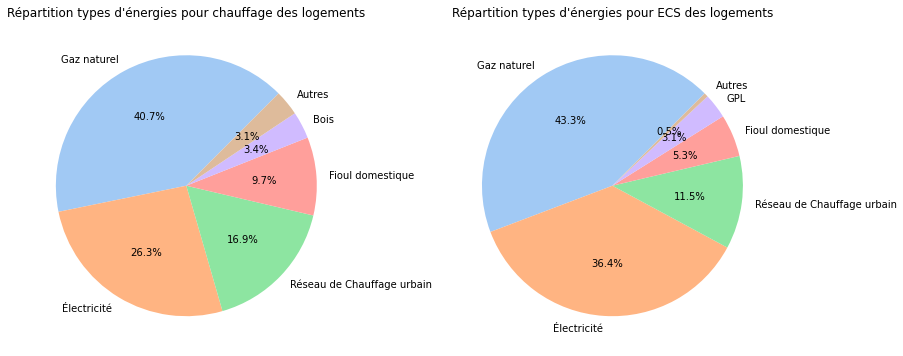

In [ ]:
# Analyse descriptive de la base de donnée : 
bd_dpe = df.copy()

# répartition des types d'energies de chauffage  des logements : 
comptage_type_energie = bd_dpe['Type_énergie_principale_chauffage'].value_counts()


### REPRESENTATION GRAPHIQUE 
# Calcul des pourcentages pour chaque type d'énergie
pourcentages_chauffage = (comptage_type_chauffage / len(bd_dpe)) * 100
pourcentages_ECS = (comptage_type_ECS / len(bd_dpe)) * 100

# Seuil pour regrouper les petites catégories sous "Autres"
seuil = 3

# Regroupement des petites catégories sous "Autres" si leur pourcentage est inférieur au seuil
autres_chauffage = pourcentages_chauffage[pourcentages_chauffage < seuil].sum()
autres_ECS = pourcentages_ECS[pourcentages_ECS < seuil].sum()

# Création de nouveaux tableaux pour le graphique avec "Autres"
nouveaux_pourcentages_chauffage = pourcentages_chauffage[pourcentages_chauffage >= seuil]
nouveaux_pourcentages_chauffage['Autres'] = autres_chauffage

nouveaux_pourcentages_ECS = pourcentages_ECS[pourcentages_ECS >= seuil]
nouveaux_pourcentages_ECS['Autres'] = autres_ECS

# Création des graphiques
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Graphique pour le chauffage
axes[0].pie(x=nouveaux_pourcentages_chauffage, labels=nouveaux_pourcentages_chauffage.index, startangle=45,
            colors=sns.color_palette('pastel', len(nouveaux_pourcentages_chauffage)), autopct='%1.1f%%')
axes[0].set_title('Répartition types d\'énergies pour chauffage des logements')

# Graphique pour l'ECS
axes[1].pie(x=nouveaux_pourcentages_ECS, labels=nouveaux_pourcentages_ECS.index, startangle=45,
            colors=sns.color_palette('pastel', len(nouveaux_pourcentages_ECS)), autopct='%1.1f%%')
axes[1].set_title('Répartition types d\'énergies pour ECS des logements')

# Affichage des graphiques
plt.show()


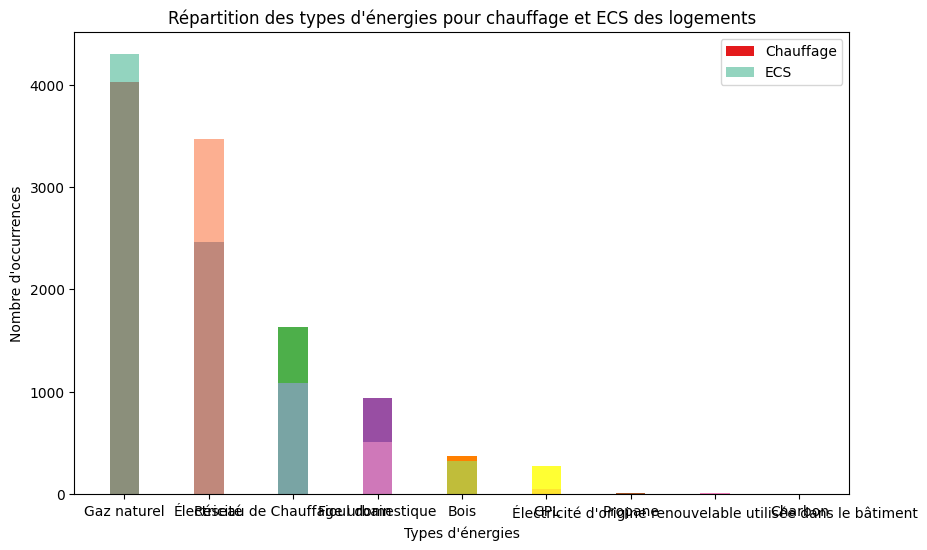

In [ ]:

# TYPE DE REPRESENTATIONA REVOIR /!\ pas tres visuelle

# Comptage pour 'Type_énergie_principale_chauffage'
comptage_type_chauffage = bd_dpe['Type_énergie_principale_chauffage'].value_counts()
colors_ECS = sns.color_palette('Set2')[0:len(comptage_type_ECS)]

# Comptage pour 'type_principale_energie_ECS'
comptage_type_ECS = bd_dpe['Type_énergie_principale_ECS'].value_counts()
colors_chauffage = sns.color_palette('Set1')[0:len(comptage_type_chauffage)]

# Création du graphique en barres superposées
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(comptage_type_chauffage))

# Barres pour 'Type_énergie_principale_chauffage'
plt.bar(index, comptage_type_chauffage, bar_width, color=colors_chauffage, label='Chauffage')

# Barres pour 'type_principale_energie_ECS'
plt.bar(index, comptage_type_ECS, bar_width, color=colors_ECS, label='ECS', alpha=0.7)

# Ajout des labels, titres, et légende
plt.xlabel('Types d\'énergies')
plt.ylabel('Nombre d\'occurrences')
plt.title('Répartition des types d\'énergies pour chauffage et ECS des logements')
plt.xticks(index, comptage_type_chauffage.index)
plt.legend()

# Affichage du graphique
plt.show()

## GEOLOCALISATION : 
Repésentation géographique des données à l'aide de géopandas 

In [ ]:
# debut des explorations

In [ ]:
create_unique(df)

,Column_name,Data_type,Number_of_unique,Number_of_missing,Unique_values
0,Type_énergie_n°1,object,11,0,"[Gaz naturel, Réseau de Chauffage urbain, Élec..."
0,Type_énergie_n°2,object,10,1684,"[Bois – Bûches, Électricité, Gaz naturel, nan,..."
0,Type_ventilation,object,36,3112,More than 15 unique values
0,Qualité_isolation_plancher_bas,object,4,0,"[très bonne, insuffisante, moyenne, bonne]"
0,Qualité_isolation_murs,object,4,0,"[insuffisante, bonne, très bonne, moyenne]"
0,Hauteur_sous-plafond,float64,39,0,More than 15 unique values
0,Surface_habitable_logement,float64,1683,0,More than 15 unique values
0,Code_postal_(brut),object,2856,0,More than 15 unique values
0,Période_construction,object,10,0,"[avant 1948, 1948-1974, 1975-1977, 2006-2012, ..."
0,Type_énergie_principale_ECS,object,11,0,"[Gaz naturel, Réseau de Chauffage urbain, Élec..."


Analyse de corrélations (via des graphes et probablement une carte)

In [ ]:
# Répartition des données entre données d’entrainement et celles de validation
x=df.iloc[:,[5,6,7,12,13,14,15,16,17,19,20]]
y=df["Etiquette_DPE"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1)


In [ ]:
#instanciation
model_DT = DecisionTreeClassifier()
#training
model_DT.fit(X_train, y_train)
#Prédiction
prediction = model_DT.predict(X_test)
# Evaluation
print(model_DT.score(X_train, y_train))
print(model_DT.score(X_test, y_test))

scores = cross_val_score(model_DT, x, y, cv=5)
print(scores)

# MAUVAISE PERFORMANCE (OVERFITTING)


0.990755535265921
0.4948665297741273
[0.50256674 0.48741654 0.49357987 0.46533128 0.47817155]


In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)  # Vous pouvez ajuster les hyperparamètres selon vos besoins

# Entraînez le classificateur sur l'ensemble d'entraînement
clf.fit(X_train, y_train)

# Faites des prédictions sur l'ensemble de test
y_pred = clf.predict(X_test)

# Évaluez les performances du modèle
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# A REVOIR, JE COMPRENDS PAS TROP CES GRANDEURS

Accuracy: 0.5523613963039015
Classification Report:
              precision    recall  f1-score   support

           A       0.00      0.00      0.00         6
           B       0.70      0.50      0.58        32
           C       0.73      0.73      0.73       332
           D       0.50      0.60      0.54       284
           E       0.43      0.41      0.42       189
           F       0.30      0.25      0.27        72
           G       0.39      0.22      0.28        59

    accuracy                           0.55       974
   macro avg       0.43      0.39      0.40       974
weighted avg       0.55      0.55      0.55       974

Confusion Matrix:
[[  0   2   3   1   0   0   0]
 [  0  16  11   5   0   0   0]
 [  1   3 243  67  17   1   0]
 [  0   1  61 171  38  11   2]
 [  0   1   9  68  77  22  12]
 [  0   0   2  20  26  18   6]
 [  0   0   3  12  23   8  13]]
